In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [200]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import datetime as dt
from sklearn.cluster import KMeans
import random as ran
from sklearn.metrics.pairwise import euclidean_distances as euc

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

from src.dbc import TimeDivisionKMeans
from src.dbc.utils import data_preprocessing, \
        dimension_reduction, \
        calc_contribution, \
        calc_contribution_rank, \
        remove_anomaly

import src.crs as crs

In [3]:
# 1. load_excel

# data/apt_all.xlsx
# data/apt_1.xlsx
# data/apt_3.xlsx
# data/apt_4.xlsx
# data/apt_std_nugin_1_3.xlsx

data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
df = data_preprocessing(xlsx)

# 3. dimension_reduction
df = dimension_reduction(df)

copy_df = df.copy()

# Load Data

In [4]:
df = copy_df[:24 * 31]
size = 3
tdKMeans = TimeDivisionKMeans(df, size=size)

df.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2018-05-01 00:00:00,0.341,0.121,0.245,0.009,0.085,0.154,0.161,0.311,0.358,0.177,...,0.372,0.181,0.322,0.374,0.571,0.453,0.161,0.127,0.259,0.364
2018-05-01 01:00:00,0.337,0.186,0.285,0.010,0.071,0.127,0.179,0.225,0.206,0.178,...,0.245,0.238,0.292,0.382,0.327,0.352,0.172,0.133,0.234,0.286
2018-05-01 02:00:00,0.324,0.214,0.487,0.009,0.061,0.139,0.182,0.221,0.150,0.152,...,0.245,0.250,0.287,0.320,0.359,0.366,0.242,0.219,0.197,0.368
2018-05-01 03:00:00,0.319,0.250,0.300,0.009,0.067,0.132,0.172,0.274,0.142,0.205,...,0.177,0.223,0.329,0.170,0.322,0.267,0.269,0.164,0.229,0.414
2018-05-01 04:00:00,0.235,0.199,0.107,0.009,0.047,0.131,0.153,0.255,0.139,0.169,...,0.129,0.171,0.301,0.168,0.351,0.255,0.170,0.132,0.198,0.318


# Time Divison KMeans Run

In [56]:
def visualization(time):
    # 전체
    _sort_ci = list()
    cluster_pattern = np.array([])
    fig,ax = plt.subplots(len(ci[0][0]), len(ci[:round(time / size)]), figsize=(16,4 * len(ci[0][0])))
    fig.subplots_adjust(wspace=0.01)

    for rank in range(0, len(ci[0][0])):
        for ci_idx, _ci in enumerate(ci[:round(time / size)]):
            _min_idx = _ci[1].argsort()[rank]
            _contribution = _ci[1][_min_idx]
            _cluster_pattern = _ci[0][_min_idx]

            household_ci = hc.iloc[ci_idx].values
            _in_cluster = np.where(household_ci == _min_idx)
            in_cluster = df.columns[_in_cluster]

            households_patterns = df[in_cluster].T.values
            x = [_ for _ in range(size * ci_idx, size * (ci_idx + 1))]
            
            max_kwh = 0
            for hp in households_patterns:
                pat = hp[size * ci_idx: size * (ci_idx + 1)]
                ax[rank][ci_idx].plot(range(size * ci_idx, size * (ci_idx + 1)), pat, color="g", linewidth=0.3)
                if pat.max() > max_kwh:
                    max_kwh = pat.max()

            ax[rank][ci_idx].plot(range(size * ci_idx, size * (ci_idx + 1)),_cluster_pattern, color="g", linewidth=2)

            ax[rank][ci_idx].spines['right'].set_visible(False)
            ax[rank][ci_idx].spines['top'].set_visible(False)

            ax[rank][ci_idx].text(x[0] ,max_kwh, 
                                  "라운드 {} / 랭크 {}".format(int(ci_idx + 1), rank + 1) ,
                                 fontsize=10,
                                 fontweight='semibold',
                                 verticalalignment ='center', 
                                 horizontalalignment ='left')

            if ci_idx > 0:
                ax[rank][ci_idx].spines['left'].set_visible(False)
                ax[rank][ci_idx].yaxis.set_ticks([])
                ax[rank][ci_idx].yaxis.set_ticklabels([])

# Time Divison KMeans
- n시간씩 군집을 만드는 기법이다.
- 가구별로 3시간별로 특정 군집에 속해있게 되며, 여기서 rank 방식으로 군집의 기여도를 판정한다.
    - 결과적으로, 계속해서 적게 쓰는 가구는 후에 낮은 랭크를 기록할 것이며, 계속해서 많이 쓰는 가구는 후에 높은 랭크를 기록할 것 이다.
- 최종적으로 만들어지는 3시간씩의 군집 행동패턴들을 종합하여 최종 기여도를 산정한다.
    - 특정 라운드에서 아웃라이어가 발생해도 전체 결과를 토대로 최종 결과가 나오기 때문에, 아웃라이어에 민감하지 않다.

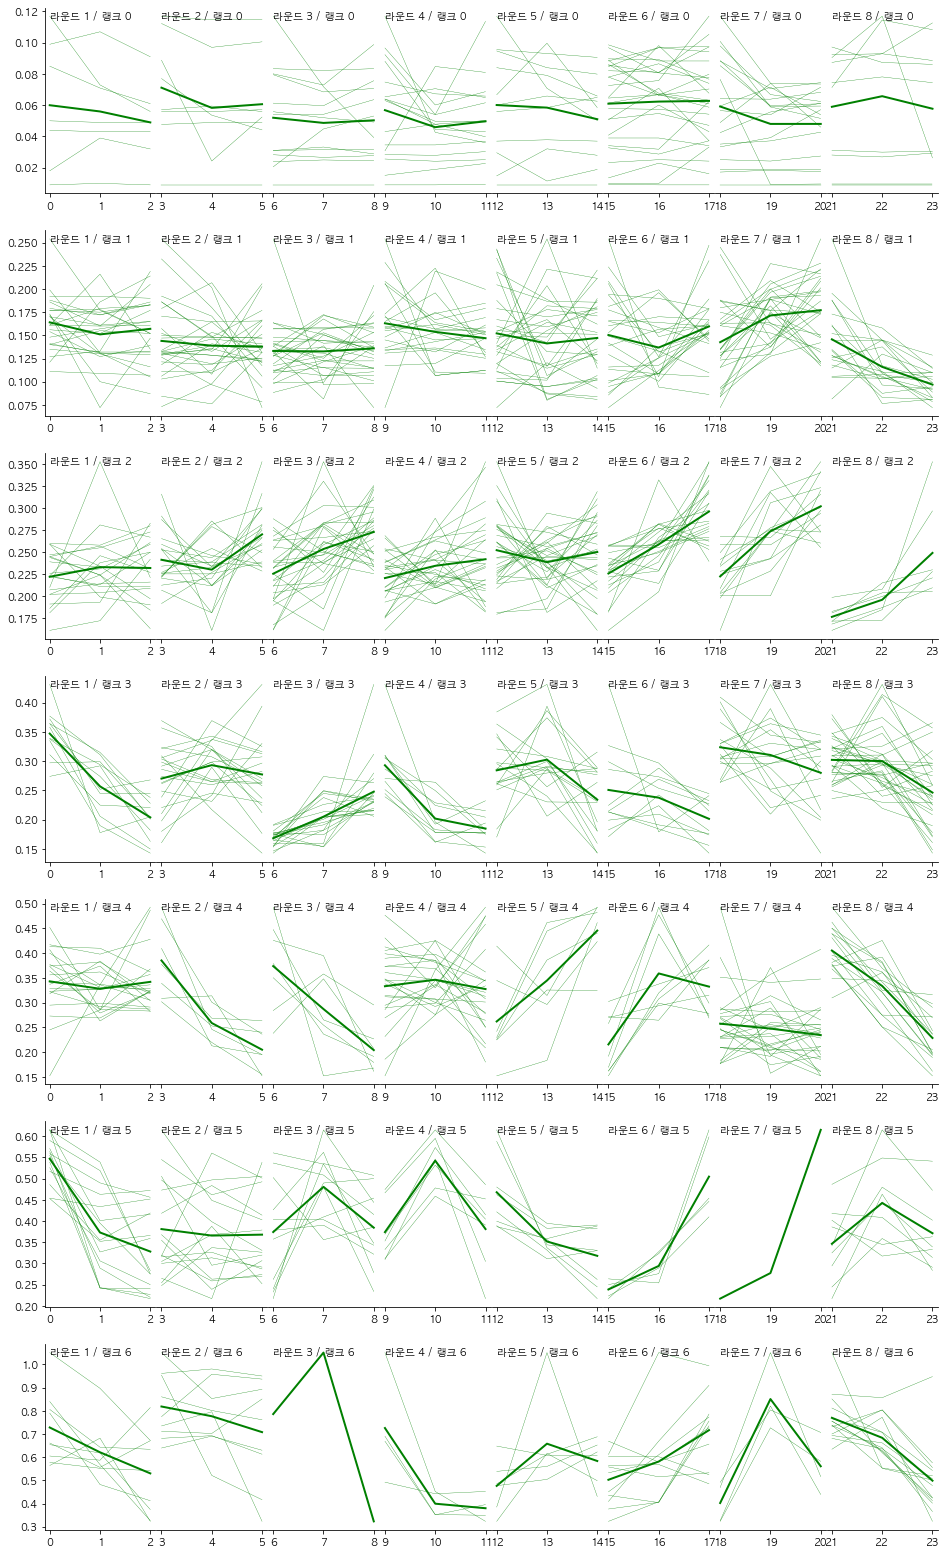

In [59]:
visualization(24)

# Contribution Map

In [380]:
contribution_df = calc_contribution_rank(hc, ci)
contribution_df.index = df.index[::size] 

contribution_df.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2018-05-01 00:00:00,5.0,2.0,5.0,1.0,1.0,2.0,2.0,4.0,4.0,2.0,...,4.0,3.0,5.0,5.0,6.0,6.0,3.0,2.0,3.0,5.0
2018-05-01 03:00:00,5.0,2.0,3.0,1.0,1.0,2.0,2.0,4.0,2.0,2.0,...,2.0,3.0,6.0,2.0,6.0,4.0,3.0,3.0,3.0,6.0
2018-05-01 06:00:00,2.0,1.0,1.0,1.0,1.0,2.0,3.0,2.0,2.0,3.0,...,1.0,5.0,5.0,3.0,5.0,5.0,3.0,3.0,5.0,5.0
2018-05-01 09:00:00,2.0,2.0,1.0,1.0,1.0,3.0,3.0,3.0,6.0,1.0,...,1.0,6.0,3.0,5.0,5.0,5.0,1.0,3.0,3.0,5.0
2018-05-01 12:00:00,2.0,2.0,1.0,1.0,1.0,2.0,3.0,3.0,6.0,2.0,...,4.0,4.0,4.0,4.0,6.0,3.0,2.0,3.0,3.0,6.0


# Problem 1. 총 사용량이 많지만, 최종 기여도가 낮은 가구의 존재 (Anomaly)
- 특정 요일에 전기를 워낙 적게 써서 나타난 현상으로, 해당의 경우에는 총사용량을 토대로 해당 이상치로 판단되는 가구가 현재의 그룹에 어울리는지 다음 랭크 기여도 그룹에 어울리는 지를 판단한다.
- 이는 기여도 산출에 rank 방식을 이용한 이유였다. 클러스터링 percentage 방식으로 기여도를 적용할 경우, 총 사용량이 높은 가구가 특정 요일에 percentage가 워낙 적게 나와 마지막 기여도 종합 단계에서 문제를 보여줬었다. 아래의 함수로 이러한 이상치들을 제거해준다.

### 1. Remove Anomaly

In [476]:
cont_mean_df = remove_anomaly(df, contribution_df)

cont_mean_df.head()

,contribution
아파트1-104-1206,2.0
아파트1-104-303,2.0
아파트1-104-1307,2.0
아파트1-104-1208,1.0
아파트1-104-408,1.0


- 이상치가 제거된 형태의 최종 기여도

In [477]:
print("{} ~ {} 까지의 기여도 그룹이 만들어졌다.".format(
    cont_mean_df['contribution'].min(), cont_mean_df['contribution'].max()))
cont_count = pd.DataFrame(
    cont_mean_df['contribution'].groupby(cont_mean_df['contribution']).count()
)
cont_count.columns = ['그룹 멤버 수']
cont_count

1.0 ~ 6.0 까지의 기여도 그룹이 만들어졌다.


,그룹 멤버 수
contribution,
1.0,7
2.0,15
3.0,33
4.0,24
5.0,24
6.0,5


# 대표 클러스터링 패턴 선정
- 각 기여도 그룹의 가구들은 n시간 마다 특정 군집에 속해있었다.
- 특정 기여도 그룹의 n개의 시간대의 대표 클러스터링 패턴 선정은 해당 그룹의 멤버들이 가장 많이 속해 있었던 클러스터링으로 선정을 하겠다.

In [479]:
# Cluster by Contribution GroupBy
cc = pd.DataFrame()
cont_group = set(cont_mean_df.values.flatten())

for group in cont_group:
    group_cols = cont_mean_df[cont_mean_df['contribution'] == group].index
    _hc = hc[group_cols].T.copy()
    _clusters = np.array([])
    
    for idx in range(0, len(hc)):
        _group = _hc[idx].groupby(_hc[idx]).count()
        max_cluster = _group.argmax()

        _clusters = np.append(_clusters,
                              _group.keys()[max_cluster])
    
    cc["기여도 그룹 {}".format(int(group))] = _clusters
    
cc.head()

,기여도 그룹 1,기여도 그룹 2,기여도 그룹 3,기여도 그룹 4,기여도 그룹 5,기여도 그룹 6
0,5.0,3.0,3.0,0.0,4.0,1.0
1,2.0,4.0,4.0,1.0,3.0,0.0
2,3.0,4.0,5.0,0.0,0.0,1.0
3,1.0,4.0,6.0,6.0,2.0,2.0
4,3.0,5.0,5.0,1.0,2.0,4.0


## 선정된 대표 클러스터링의 패턴 파싱하기

In [480]:
cc_cols = cc.columns
_cc_pattern = np.array([])

for cc_col in cc_cols:
    _cc = cc[cc_col]
    for division_round, _cc in enumerate(_cc):
        _round_pattern = ci[division_round][0][int(_cc)]
        
        _cc_pattern = np.append(_cc_pattern,_round_pattern)
        
cc_pattern = pd.DataFrame(_cc_pattern.reshape(-1,len(cc) * 3),
                         index=cc_cols,
                         columns=df.index).T
cc_pattern.head()

,기여도 그룹 1,기여도 그룹 2,기여도 그룹 3,기여도 그룹 4,기여도 그룹 5,기여도 그룹 6
2018-05-01 00:00:00,0.060,0.164,0.164,0.547,0.343,0.728
2018-05-01 01:00:00,0.056,0.151,0.151,0.373,0.328,0.621
2018-05-01 02:00:00,0.049,0.157,0.157,0.328,0.342,0.530
2018-05-01 03:00:00,0.062,0.164,0.164,0.207,0.357,0.515
2018-05-01 04:00:00,0.051,0.159,0.159,0.193,0.350,0.493


# 시각화

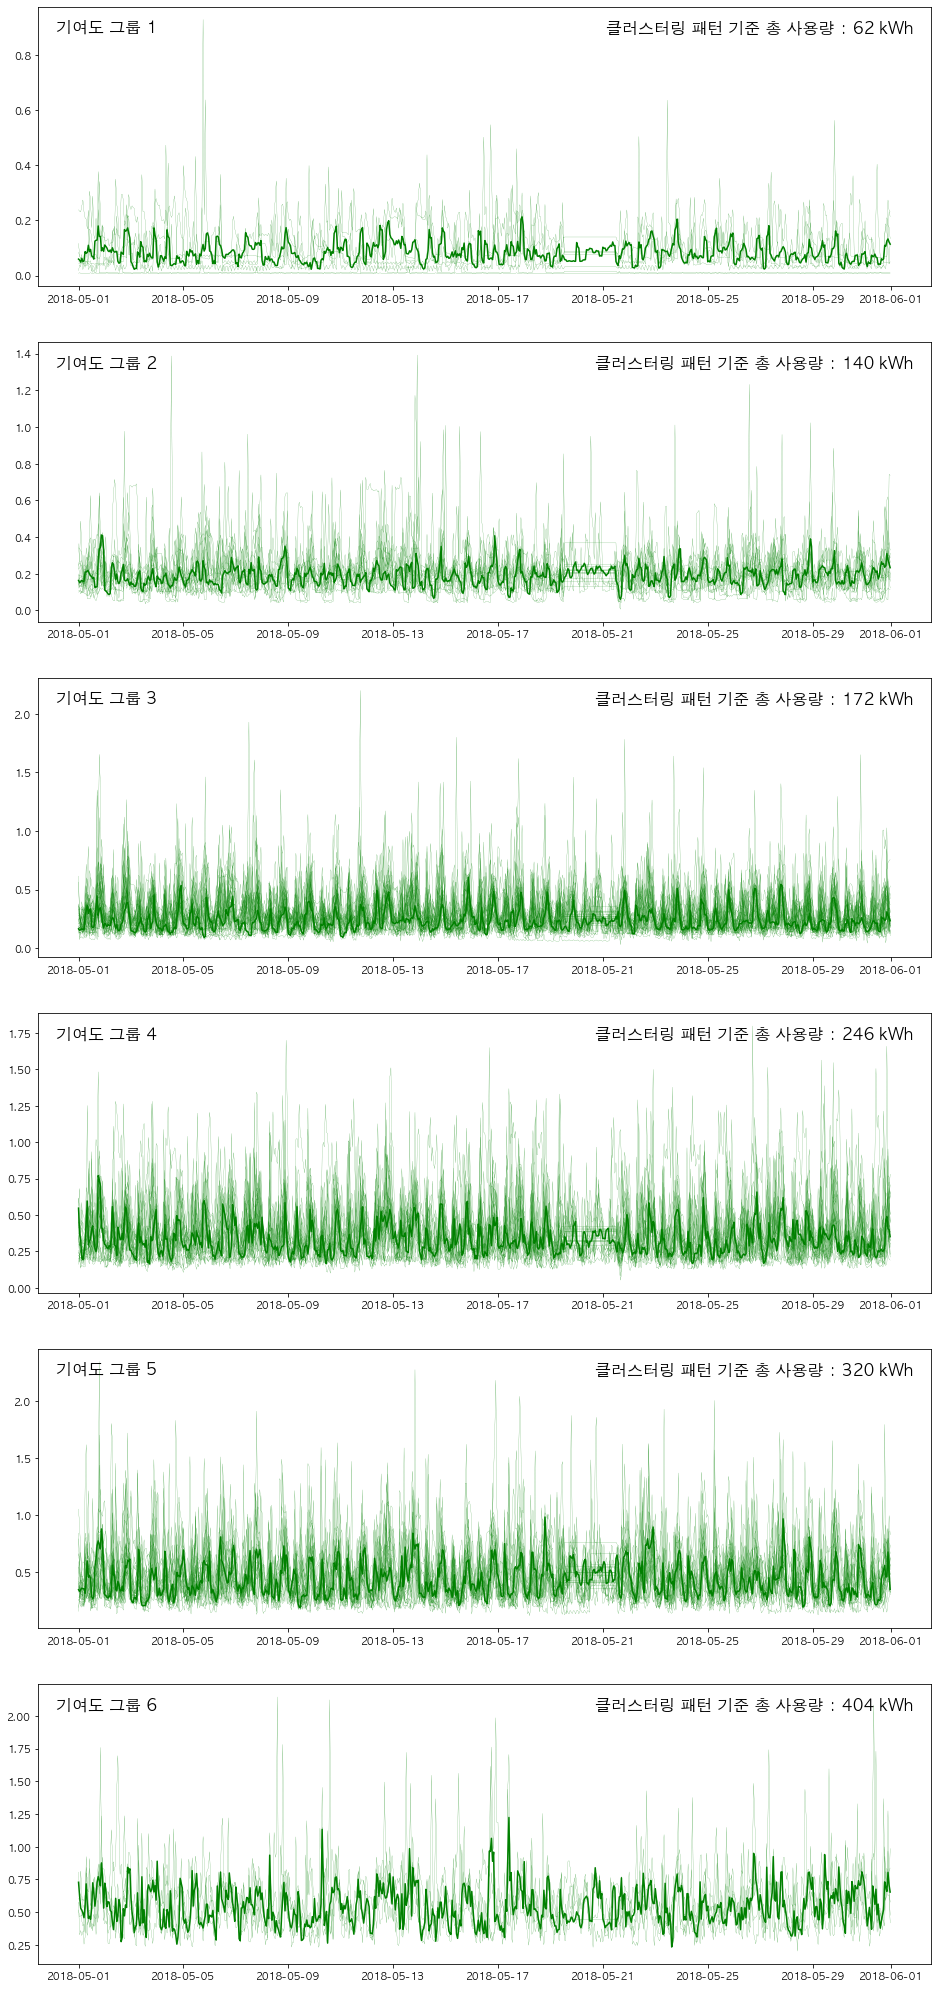

In [481]:
fig, ax = plt.subplots(len(cc_cols),1, figsize=(16, 6 * len(cc_cols)))

for group_idx,group in enumerate(cont_group):
    cols = df.columns
    _group_cols = cols[(cont_mean_df['contribution'] == group).values]

    ax[group_idx].plot(df[_group_cols], linewidth=0.15, color='g')
    ax[group_idx].plot(cc_pattern[cc_cols[group_idx]], linewidth=1.5, color='g')
    ax[group_idx].text(0.02, 0.925, cc_cols[group_idx], 
                       ha='left', 
                       va='center',
                       fontsize=16,
                       transform=ax[group_idx].transAxes)
    ax[group_idx].text(0.98, 0.925, "클러스터링 패턴 기준 총 사용량 : {} kWh".format(round(cc_pattern[cc_cols[group_idx]].sum())), 
                       ha='right', 
                       va='center',
                       fontsize=16,
                       transform=ax[group_idx].transAxes)

plt.show()

# 기여도 산정 방식

## 그룹 == 랭크
- 각 그룹의 번호는 랭크를 나타내기도 한다. 이를 통해 그대로 선정해도 된다.

In [495]:
ranks = np.array(list(cont_group))
["{}%".format(int(_)) for _ in (ranks / ranks.sum() * 100).round()]

['5%', '10%', '14%', '19%', '24%', '29%']

## 클러스터링 패턴 기준 총 사용량
- 위에서 파싱한 클러스터링 패턴을 기여도로 이용해도 된다.
- 전체 기여도 (100 == 모든 클러스터링 패턴)

In [493]:
(((cc_pattern.sum() / cc_pattern.sum().sum()) * 100).round()).map(lambda x: "{}%".format(int(x)))

기여도 그룹 1     5%
기여도 그룹 2    10%
기여도 그룹 3    13%
기여도 그룹 4    18%
기여도 그룹 5    24%
기여도 그룹 6    30%
dtype: object

# 분산을 구해봅시다